In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pandas_plink as pp
from src import setup
# This prevents to restart the kernel whenever an external file is edited
%load_ext autoreload
%autoreload 2

# Scripts: see below (computation management)
RUN_SCRIPTS = True
DEFAULT_RECOMPUTE = False
# 
DATA_THINNING = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction

**14'738'460 variants, 622 people.**

## Computation management

<s>
We run all the bash scripts with the function below. Idea: two separate procedures, depending on wether the computations have already been done locally. Principle:

1. Call of the custom function `run(path)` and hide output by default.
    * If `RUN_SCRIPTS` == False, simply do nothing
    * If `RUN_SCRIPTS` == True, run the script
1. `cat` the log file.

Example: while coding or after importing source code, put `RUN_SCRIPTS = True`. While re-running a notebook (ex: check that the code runs), put `RUN_SCRIPTS = False`.
</s>

### Idea

Sometimes we don't want to re-do all the computations if the resulting data is already calculated. Thus we provide:
1. A way of easily running shell commands
1. A dedicated function to easily run plink commands on the shell
1. A way of checking if the results already exist, and loading data if this is the case
    * Unless we specifically specifiy to re-do the calculations.

DOCUMENTATION about running shell commands and managing the outputs : https://janakiev.com/til/python-shell-commands/, https://www.pythonforbeginners.com/os/subprocess-for-system-administrators

### General principle

* `run_shell_command`: manage to run shell commands with a specific package (`subprocess`) that helps to manage the outputs.
* `run_plink`: manage plink version, binary files location, output location, display errors, check if results already exist

**NOTE: possible improvement: automatically find the file extension. Also, if the command results in several output files, we should check that all of them are present (but we assume the user doesn't make such dumb things, i.e. deleting only a fraction of the output files.**

Workflow:
1. Call `run_plink` command with the specific command (e.g. `--freq`), the input, the output and the file extension to look for (to avoid re-doing the computations). 
1. The function checks if the result already exist (needs the output and the extension resulting from the command)
    * already exists: display a message, abort the process (returns 2-tuple of empty strings). This occurs if `force==False` (which is the default value).
1. The command is runned with plink2 by default
1. The error messages are displayed (by default, `verbose_err=True`)
1. The outputs are returned as a tuple (stdout, stderr)

In [23]:
import subprocess
import os.path

def run_shell_command(cmd_lst) :
    """Returns a tuple: (stdout, stderr).
    Note: you must separate the options from their values.
    Note: the output is returned when all calculations are done
    Example: you want 'plink --bfile <file> ...'. Must provide cmd_list=['plink', '--bfile', '<file>', ...]"""
    process = subprocess.Popen(cmd_lst, stdout=subprocess.PIPE, 
                               stderr=subprocess.PIPE, universal_newlines=True)
    return process.communicate()

def run_plink(command, file, out, extension, plink2=True, verbose_err=True, force=DEFAULT_RECOMPUTE):
    """Returns a tuple: (stdout, stderr).
    Note: command input must have the options/values separated by a single space"""
    #if RUN_SCRIPTS == False: return
    # Check is result already exist
    if force==False and os.path.exists(out+'.'+extension): 
        print("run_plink: command '{}', the file '{}' already exists (force is set to False)."
             .format(command, out+'.'+extension))
        # ABORT !
        return ('run_plink was aborted', '')
    # Construct the shell commands
    lst = []
    # Determine plink version to use
    lst.append('plink2' if plink2 else 'plink')
    # Input and output
    lst.append('--bfile'); lst.append(file)
    lst.append('--out');   lst.append(out)
    # Must separate the options from their values (see run_shell_command)
    commands = command.split(' ')
    for c in commands :
        lst.append(c)
    # Provide values to the run_shell_command function
    stdout, stderr = run_shell_command(lst)
    # Display errors
    if stderr and verbose_err : print(stderr)
    # Return the outputs
    return stdout, stderr

In [20]:
path_raw = setup.PATH_HOST_RAW_PLINK_DATA

## Overview on raw data

### Files

In [5]:
path = setup.PATH_HOST_RAW_DATA
!ls -lh $path

total 4.0G
-rwxr-xr-x 1 mazeller SV-BA4-unit  245 Aug  9 16:11 dictionary_wes_vcf.txt
-rwxr-xr-x 1 mazeller SV-BA4-unit 2.2G Aug  9 16:11 hbv_gilead.bed
-rwxr-xr-x 1 mazeller SV-BA4-unit 431M Aug  9 16:11 hbv_gilead.bim
-rwxr-xr-x 1 mazeller SV-BA4-unit  18K Aug  9 16:11 hbv_gilead.fam
-rw-r--r-- 1 mazeller SV-BA4-unit 1.4G Aug 11 01:59 hbv_gilead.frq
-rw-r--r-- 1 mazeller SV-BA4-unit  930 Aug 11 01:59 hbv_gilead.log
-rw-r--r-- 1 mazeller SV-BA4-unit  13K Aug 11 01:59 hbv_gilead.nosex


Those are **plink binary files**. 

### Dictionnary of the data

In [6]:
!cat $path/dictionary_wes_vcf.txt

Info about WES_VCF by Ondrej.Podlaha@gilead.com on Dec 12 2018.

1. Human reference genome: GRCh37.87
2. Variant calling was performed using GATK (version nightly-2016-08-27-g667f78b; HaplotypeCaller)
3. dbSNP v138 was used by HaplotypeCaller
 


## Arbitrary thinning of the data

We use the plink2 `--thin <p>` option to **reduce the amount of data** (keep entries with probability p). We'll make sure that the code runs first. When everything works, we can simply set `DATA_THINNING = False`.

Management of the **data being taken into account**: we simply put `path_raw` to target the reduced data.

In [27]:
if DATA_THINNING == True :
    path_out = setup.PATH_DATA+'host_reduced'
    run_plink("--thin 0.001 --make-bed", file=path_raw, out=path_out, extension='bed')
    path_raw = path_out

run_plink: command '--thin 0.001 --make-bed', the file 'data/host_reduced.bed' already exists (force is set to False).


In [26]:
!cat $path_out'.log' | grep thin

  --thin 0.001
--thin: 14723780 variants removed (14680 remaining).


**WARNING: now, the `path_raw` variable targets the reduced data if `DATA_THINNING==True`. Moreover, this path should not be modified in any downstream procedure.**

# Missing values

`.smiss` for sample-based missing data report:
* MISSING_CT: Number of missing hardcalls, not counting het haploids
* OBS_CT = Denominator (#males on chrY, otherwise #samples)
* F_MISS = Missing hardcall rate, not counting het haploids



In [156]:
path_missing = path_raw+'_missing'
run_plink("--freq", file=path_raw, out=path_missing, extension='frq')

FileNotFoundError: [Errno 2] No such file or directory: 'plink --bfile data/host_reduced --out test --freq': 'plink --bfile data/host_reduced --out test --freq'

In [82]:
df_miss_ind = pd.read_csv(path_missing+'.smiss', sep='\s+')
df_miss_var = pd.read_csv(path_missing+'.vmiss', sep='\s+')
print("Shape of missing var table: {}\nColumns of missing var table:\n\t{}\
\nShape of missing ind table: {}\nColumns of missing ind table:\n\t{}"
     .format(df_miss_var.shape, df_miss_var.columns, 
             df_miss_ind.shape, df_miss_ind.columns))

Shape of missing var table: (14843, 5)
Columns of missing var table:
	Index(['#CHROM', 'ID', 'MISSING_CT', 'OBS_CT', 'F_MISS'], dtype='object')
Shape of missing ind table: (622, 5)
Columns of missing ind table:
	Index(['#FID', 'IID', 'MISSING_CT', 'OBS_CT', 'F_MISS'], dtype='object')


## Missing report - individuals

For each individual, plink computed the rate of missing variants. This tells us about how to filter individuals out.

In [37]:
df_miss_ind.head(1)

,#FID,IID,MISSING_CT,OBS_CT,F_MISS
0,igm160017,igm160017,11449,14823,0.772381


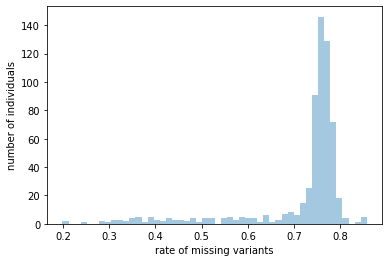

In [73]:
sns.distplot(df_miss_ind['F_MISS'], norm_hist=False, kde=False)
plt.ylabel('number of individuals'); plt.xlabel('rate of missing variants');

## Missing report - variants

For each variant, plink computed the rate of missing individuals. This tells us about how to filter variants out.

In [60]:
df_miss_var.head(1)

,#CHROM,ID,MISSING_CT,OBS_CT,F_MISS
0,1,1:17493:A:G,0,622,0.0


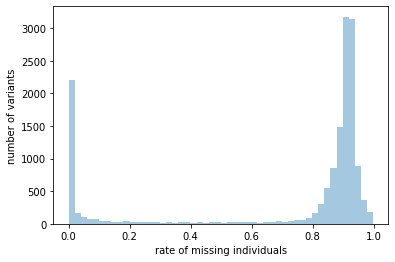

In [85]:
sns.distplot(df_miss_var.F_MISS.dropna(), kde=False, norm_hist=False)
plt.xlabel('rate of missing individuals'); plt.ylabel('number of variants');

## Summary of missing report

Report `.smiss` (individuals): for each variant, we're interested in the rate of missing individuals. We see t

In [76]:
df_miss_var = None
df_miss_ind = None

# Minor allele frequencies

In [77]:
path_freq = setup.PATH_PLINK_DATA+'freq'
def plink2_freq():
    !plink2 --bfile $path_raw --freq --out $path_freq > $setup.PATH_NULL

run(fun=plink2_freq)

In [78]:
df_freq = pd.read_csv(path_freq+".frq", sep="\s+")

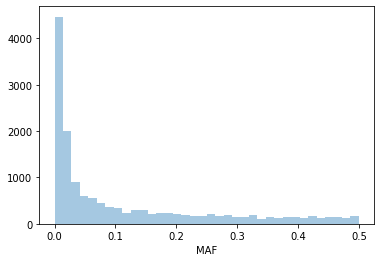

In [80]:
sns.distplot(df_freq.MAF.dropna(), kde=False, norm_hist=True);

<br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br />